In [2]:
import pandas as pd
import numpy as np

In [3]:
ladata = pd.read_csv('data/la_clean.csv')

In [4]:
ladata = ladata.drop

,Unnamed: 0,CITY,LATITUDE,LONGITUDE,STATION_NAME,STATISTICAL_CODE_DESCRIPTION,STREET,ZIP,CrimeCat,Hour,Month,Day,Year,DayOfWeek
0,1,MARINA DEL REY,33.981571,-118.460040,MARINA DEL REY,DRUNK: Alcohol,4100 ADMIRALTY WAY,90292.0,3,0,1,1,2012,7
1,2,COVINA,34.105441,-117.849251,SAN DIMAS,"BURGLARY, RESIDENCE: Night, Entry No Force",5100 GREER AVE,91724.0,7,0,1,1,2012,7
2,7,LOS ANGELES,34.043482,-118.159613,EAST LOS ANGELES,GRAND THEFT VEHICLE (GTA): Automobile/Passenge...,610 N COLONIA DE LOS CEDROS,90022.0,5,2,1,1,2012,7
3,10,LANCASTER,34.697267,-118.146393,LANCASTER,"BURGLARY, OTHER STRUCTURE: Day, Entry No Force",870 W LANCASTER BLVD,93534.0,7,15,4,21,2009,2
4,11,PASADENA,34.130000,-118.089695,TEMPLE,"BURGLARY, RESIDENCE: Day, Entry By Force",3070 GAINSBOUROUGH DR,91107.0,7,10,2,14,2012,2


In [4]:
ladf = ladata.groupby(['Year', 'Month', 'ZIP', 'CrimeCat'])['Unnamed: 0'].count()

In [5]:
ladf = ladf.unstack().reset_index()

In [6]:
ladf = ladf.fillna(0)

In [7]:
ladf.head()

CrimeCat,Year,Month,ZIP,1,2,3,4,5,6,7,8,9,10
0,2004,1,90001.0,0.0,1.0,1.0,5.0,8.0,0.0,5.0,0.0,4.0,0.0
1,2004,1,90002.0,3.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0
2,2004,1,90004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2004,1,90005.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004,1,90006.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X = ladf.drop(['Year', 'Month', 'ZIP'], axis=1).values

In [9]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
%matplotlib inline

def kmeans_all(X):
    dists = []
    scores = []
    for k in xrange(2, 10):
#         print k
        kmeanModel = KMeans(k, n_init=3)
        kmeanModel.fit(X)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        dist = cdist(X, centroids)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 10), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 10), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()

In [10]:
scaler = StandardScaler()
X_trans = scaler.fit_transform(X)

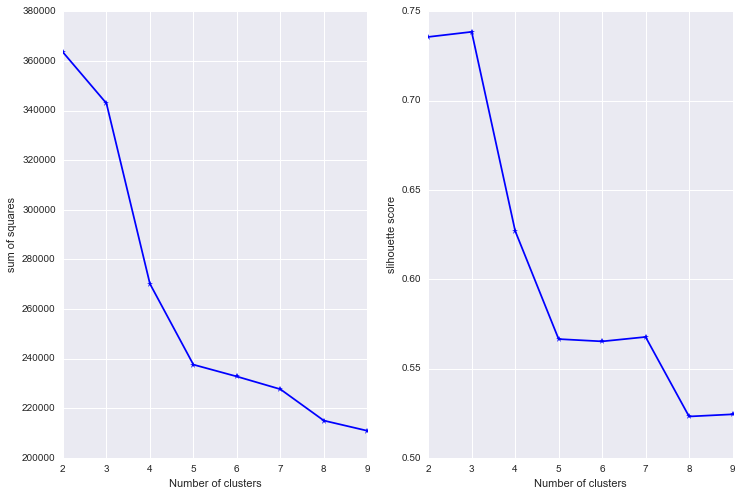

In [11]:
kmeans_all(X)

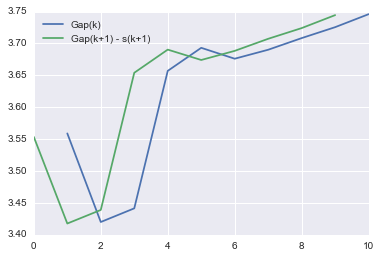

In [12]:
# returns series of random values sampled between min and max values of passed col
def get_ref(shape, tops, bots): 
    dists = tops - bots
    ref = np.random.random(shape) * dists + bots
    return ref

def iter_kmeans(refs, k):
    vals = []
    for ref in refs:
        model = KMeans(n_clusters=k, n_init=3)
        model.fit(ref)
        vals.append(np.log(model.inertia_))
    return np.array(vals)

def gap_statistic(X, max_k=10, B=10):
    gaps = []
    gaps_minus = []
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    refs = [get_ref(X.shape, tops, bots) for i in xrange(B)]
#     print refs
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(X)
        ref_log_inertias = iter_kmeans(refs, k)       
        sdk = np.std(ref_log_inertias)
#         print sdk
        gap = ref_log_inertias.mean() - np.log(km_act.inertia_)
        sk = np.sqrt(1 + 1.0/B) * sdk
#         print sk
#         print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps.append(gap)
        gaps_minus.append(gap - sk)
    plt.figure()
    plt.plot(range(1, max_k+1), gaps, label='Gap(k)')
    plt.plot(range(max_k), gaps_minus, label='Gap(k+1) - s(k+1)')
    plt.legend(loc='best')
    plt.show()
    return gaps
gaps = gap_statistic(X)

In [13]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary', 8: 'Homicide', 9: 'Sex Crime', 10: 'DUI'}

def build_nmf_all(X,k):
    nmfModel = NMF(n_components=k)
    W = nmfModel.fit_transform(X)
    H = nmfModel.components_
    print 'NMF done!'
    plot_heatmap(H.T, k)
    return W, H
    

def plot_heatmap(data, k):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(k)+0.5, minor=False, )
    ax.set_yticks(np.arange(10)+0.5, minor=False)

    # want a more natural, table-like display
#     ax.invert_yaxis()
#     ax.xaxis.tick_top()
    classLabel = ['cls-{}:'.format(i) for i in range(1, k+1)]
    ax.set_xticklabels(classLabel, minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()

def try_different_k_class(X):
    for k in xrange(2, 11):
        build_nmf_all(X, k)

NMF done!


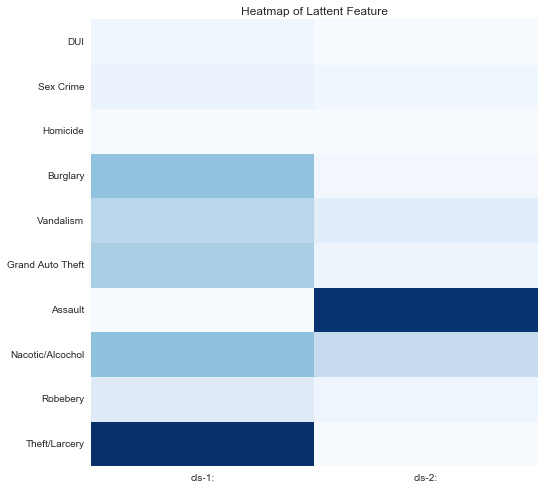

NMF done!


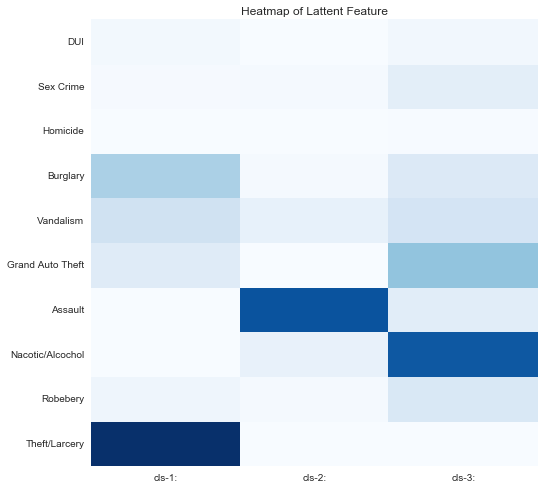

NMF done!


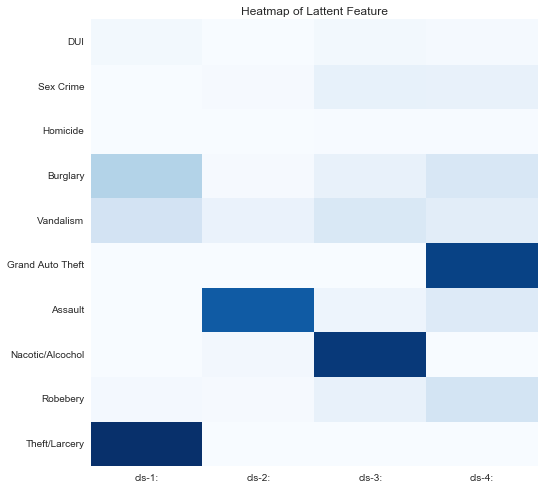

NMF done!


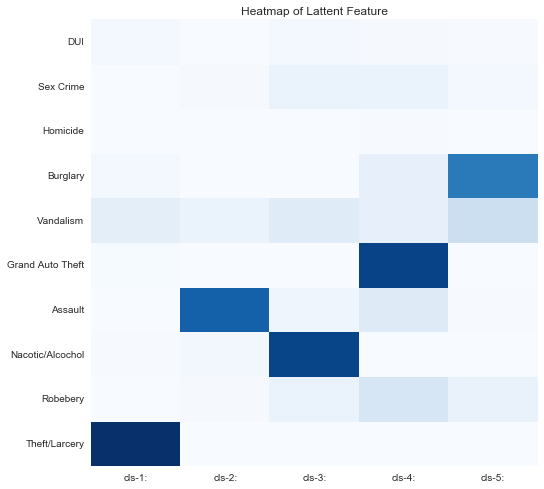

NMF done!


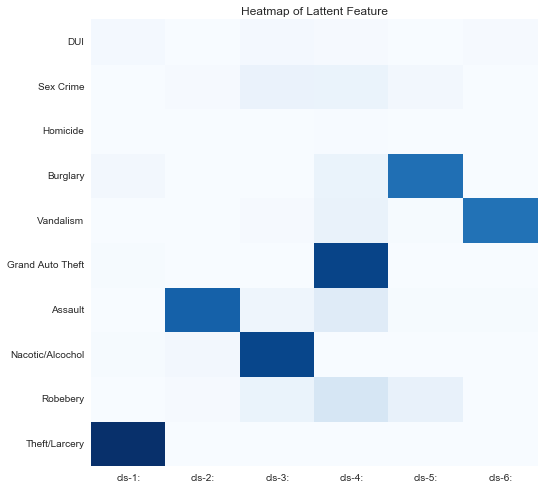

NMF done!


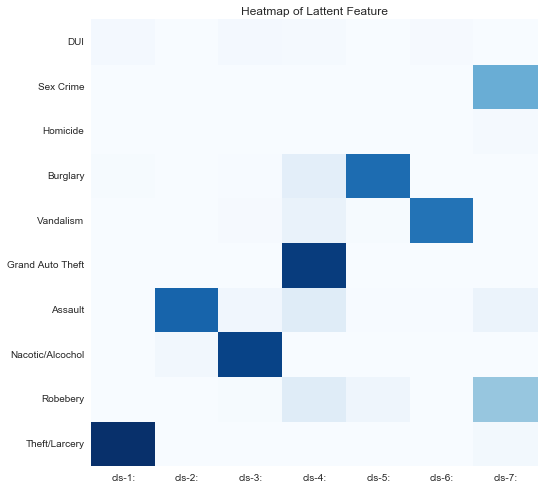

NMF done!


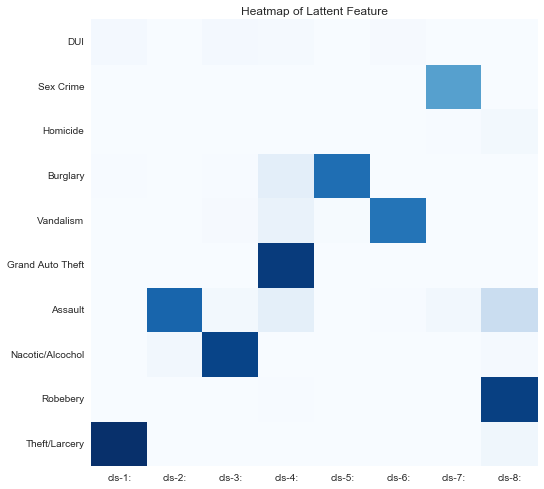

NMF done!


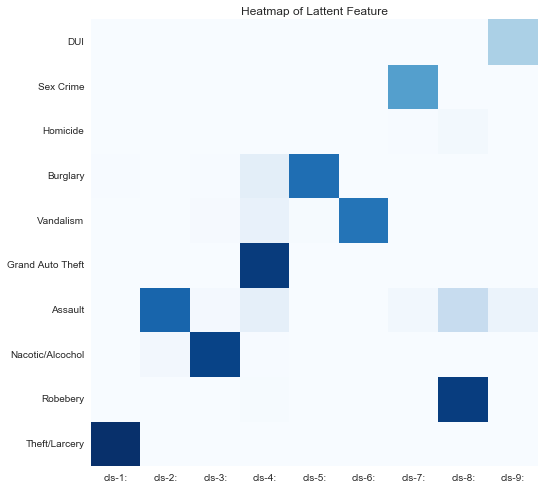

NMF done!


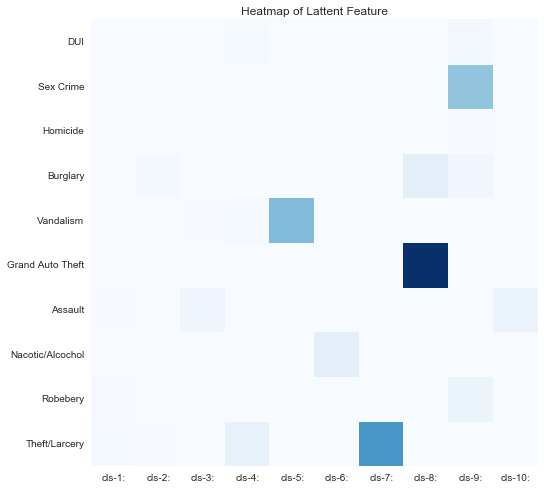

In [14]:
try_different_k_class(X)

NMF done!


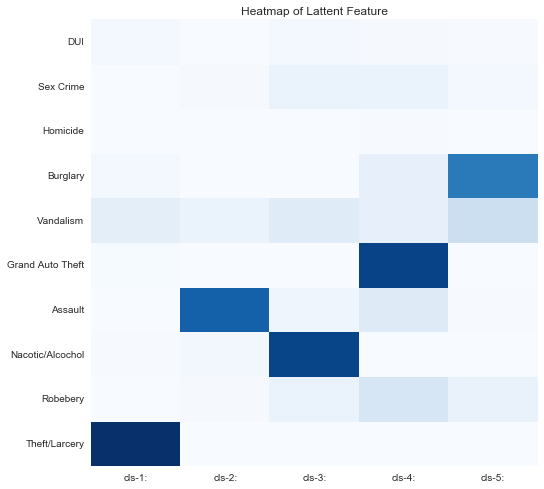

In [15]:
W, H = build_nmf_all(X, 5)

In [16]:
def build_kmean(X, k):
    model = KMeans(k, n_init=3)
    model.fit(X)
    centroids = model.cluster_centers_
    labels = model.labels_
    return centroids, labels
centroids, labels = build_kmean(X, 5)
print crimes.values()
for cent in centroids:
    print cent

['Theft/Larcery', 'Robebery', 'Nacotic/Alcochol', 'Assault', 'Grand Auto Theft', 'Vandalism', 'Burglary', 'Homicide', 'Sex Crime', 'DUI']
[ 43.9734748    4.23395225  15.88435013  15.15809019   9.80742706
  12.64986737  17.28381963   0.15809019   2.52679045   1.67480106]
[ 2.07361695  0.27087543  1.05575883  1.1659112   0.49287314  0.92305172
  1.00846486  0.01354377  0.20687019  0.04729398]
[ 15.87110378   2.01961863   8.95691236   8.71983865   3.7086542
   6.54418775   7.79482948   0.10194353   1.43344334   0.71213788]
[ 62.97244094  12.72047244  46.51377953  40.64665354  34.53543307
  24.43405512  28.04724409   0.52165354   7.3523622    3.52854331]
[  6.27777778e+00   1.37847222e+00   1.76388889e+01   1.15399306e+02
   7.15277778e-01   1.01979167e+01   2.24305556e+00   1.21527778e-01
   1.99305556e+00   1.00694444e-01]


In [17]:
for cent in H:
    print cent

[ 59.63213204   0.           0.42369183   0.           0.48710318
   5.88859854   1.56708206   0.           0.           1.35761687]
[  0.10336061   0.8187964    1.72334033  48.42813151   0.           3.7510984
   0.           0.07940828   0.87973326   0.        ]
[  0.           3.83976219  55.1671675    2.99359894   0.           7.17076183
   0.           0.23205754   4.16380433   1.49977399]
[  0.07294942  10.00234761   0.           7.55579388  55.41858872
   5.06114092   5.00331128   0.29420307   3.98421055   0.91474172]
[  0.           4.33723414   0.           0.42963795   0.          13.19234294
  42.82558265   0.14421034   1.50211268   0.32122613]


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

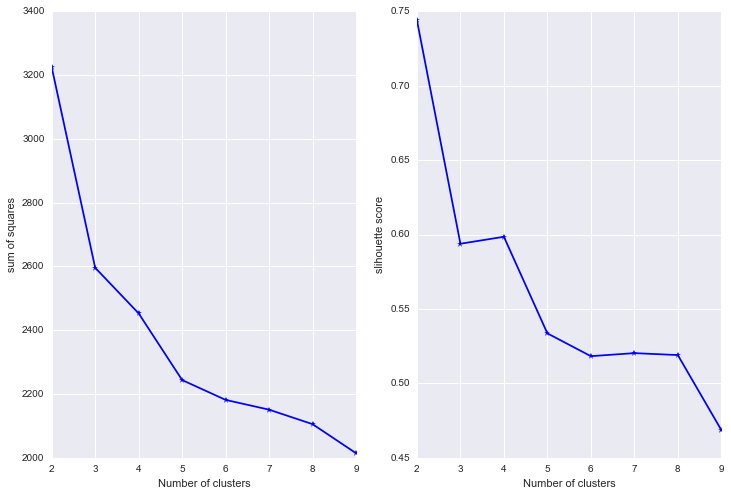

In [19]:
kmeans_all(X_scaled)

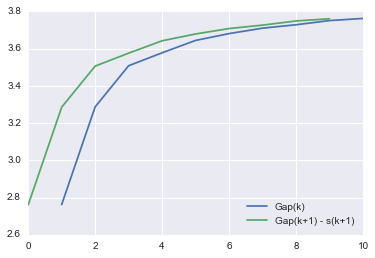

In [20]:
gaps = gap_statistic(X_scaled)

NMF done!


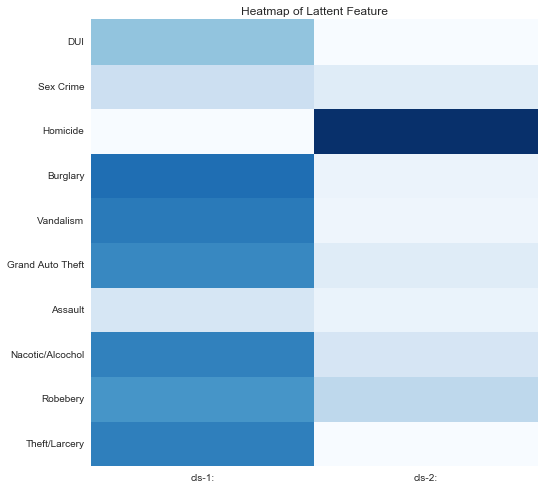

NMF done!


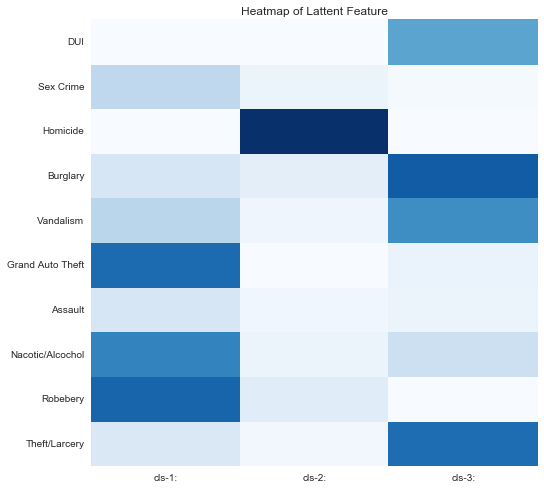

NMF done!


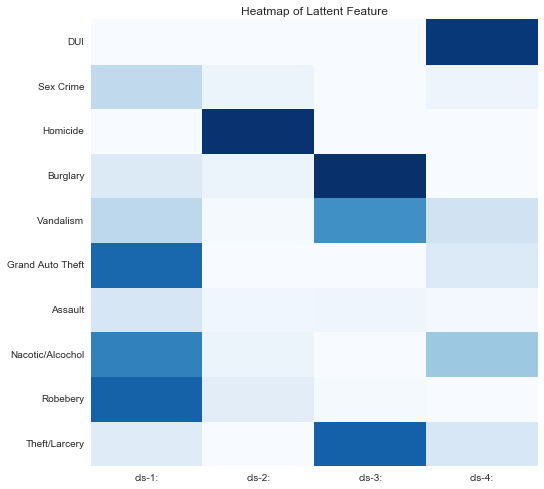

NMF done!


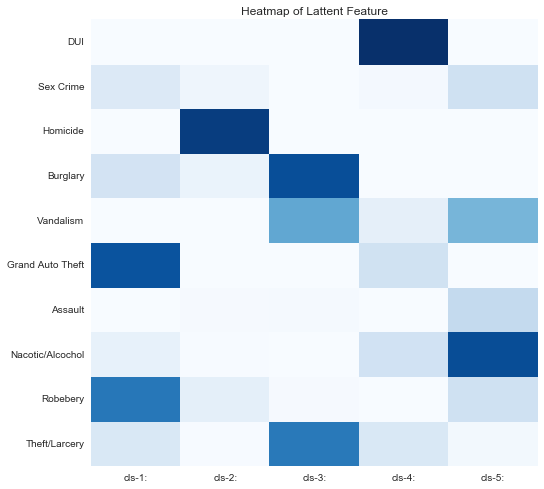

NMF done!


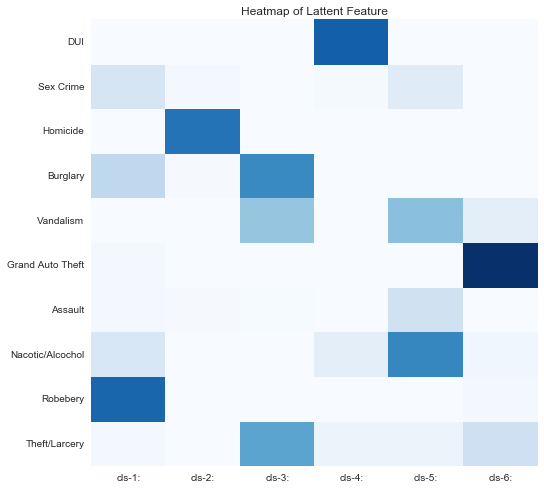

NMF done!


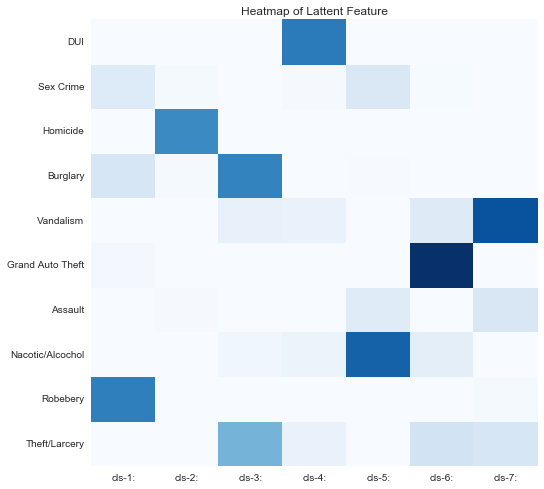

NMF done!


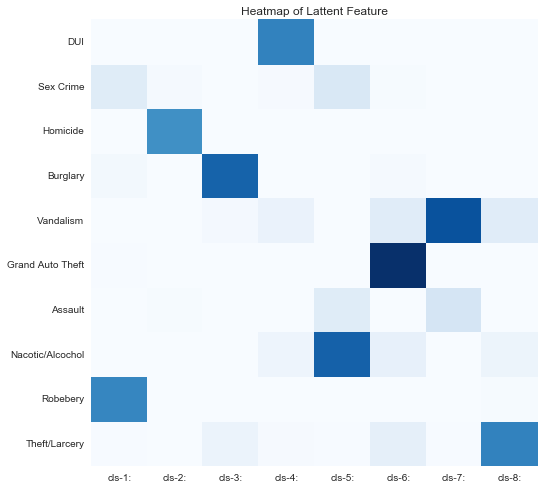

NMF done!


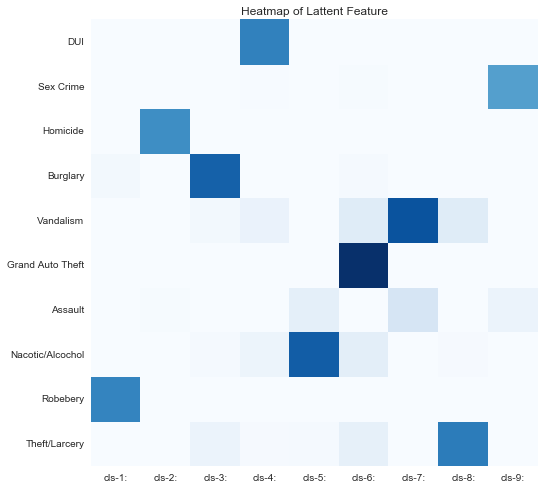

NMF done!


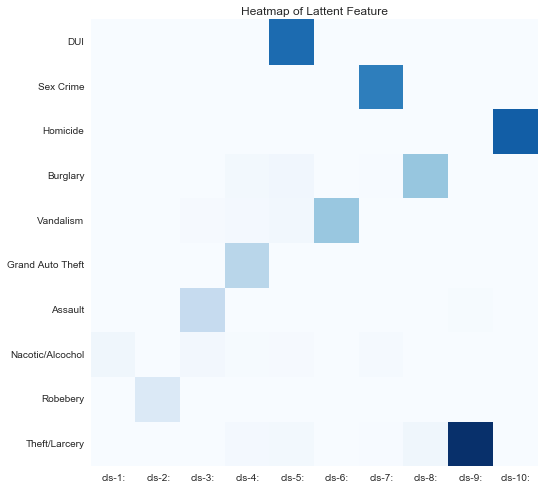

In [21]:
try_different_k_class(X_scaled)

In [22]:
def get_class_nmf(w):
    m = w.shape[1]
    n = w.shape[0]
    clusters = []
    for i in xrange(m):
        idx = np.argsort(w[:, i])[::-1][:100]
        clusters.append(idx)
        print i, idx

In [23]:
get_class_nmf(W)

0 [25529 25142 25519 25329 25333 24758 25515 25523 24950 25337 24755 25343
 25146 17815 25144 25151 25521 17628 24762 24954 25476 24946 25290 25335
 25139 17437 24768  1847   718 24760  1681  1524 16720  7913 22450 23196
 20618 17259 16541 20259 18745  1526  1845 21500 18192   881 20069  1045
  8273 24686 18383   567  8456 24947  2089 22258 18563  7570 18004 19116
 25031 19684 25140  1534  1047  9164  5170  1528  1211 18936 24567 25268
 17438 21179  4111    79    76  1841    74 26671 13048 24576   407   248
  8991 25593  7565 15642 17080 21142 20398 20992  1215  2489 19492 25330
 25443 19883 19304 24370]
1 [25058 25435 24678 24871 25247 26176 26371 25986 25802 23900 24484 26575
 24288 25625 21835 24091 23718 21646 21462 25386 21286   976 22973 24809
 25007 22217   337 22603 22415 19418   813 19606  4947 23341 21104 20539
 22032 19996 20364  3950     8 23156 19228 22782 20732  4123 25569  2763
   659 20913 18301 19810 23534 25195  2267 26773   173 18859 19043  1460
  3282 18494  1622  6

(-118.94469074608364, 32.7952008298079, -117.64637387599755, 34.82329918842445)


(311,
 5,
 [-118.94469074608364, 32.7952008298079, 0.0, 0.0],
 [-117.64637387599755, 34.82329918842445, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x119b26150>)

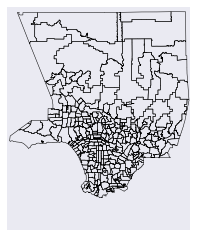

In [24]:
from mpl_toolkits.basemap import Basemap
import fiona
from shapely.geometry import shape, mapping
from pyproj import Proj, transform
from fiona.crs import from_epsg
from itertools import chain
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from matplotlib.collections import PatchCollection


shapefile="map/LA-ZIPCodes/geo_export_1cf2ba2c-a35e-47e7-a586-b3ff394055e9.shp"
shp = fiona.open(shapefile)
bds = shp.bounds
print (bds)

shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

m = Basemap(
    projection='tmerc',
    lon_0= -118.2437,
    lat_0= 34.0522,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
#     llcrnrlat=coords[1] - extra + 0.01 * h,
    llcrnrlat=33.5 - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'map/LA-ZIPCodes/geo_export_1cf2ba2c-a35e-47e7-a586-b3ff394055e9',
    'LA',
    color='black',
    zorder=2)


In [25]:
layr = ladata.groupby(['Year', 'ZIP', 'CrimeCat'])['Unnamed: 0'].count()
layr = layr.unstack().reset_index()
layr = layr.fillna(0)
layr.head()

CrimeCat,Year,ZIP,1,2,3,4,5,6,7,8,9,10
0,2004,90000.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2004,90001.0,85.0,45.0,77.0,109.0,120.0,28.0,90.0,6.0,19.0,1.0
2,2004,90002.0,12.0,15.0,12.0,19.0,19.0,5.0,15.0,2.0,2.0,0.0
3,2004,90003.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
4,2004,90004.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0


In [26]:
years = layr['Year']
yrs = sorted(years.unique())

In [27]:
X_yr = layr.drop(['Year', 'ZIP'], axis=1).values

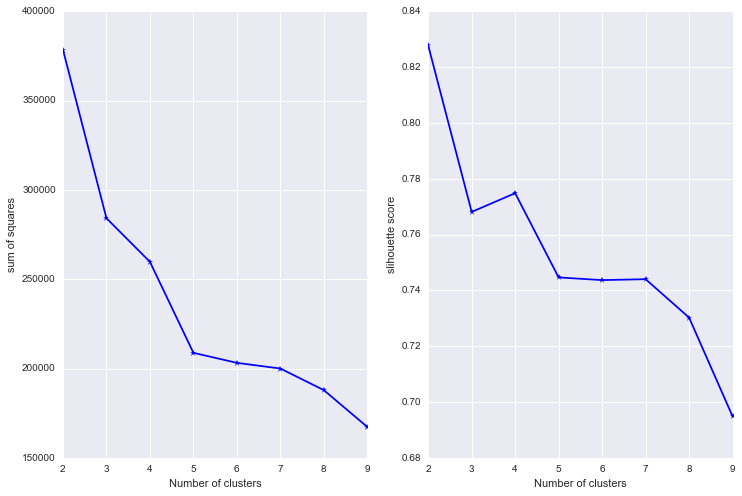

In [28]:
kmeans_all(X_yr)

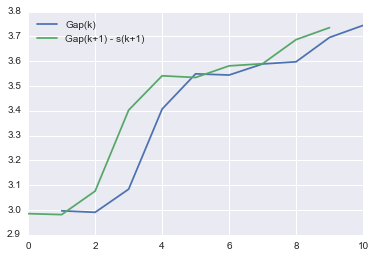

In [29]:
gaps = gap_statistic(X_yr)

In [30]:
cents, labels_yr = build_kmean(X_yr, 5)

In [31]:
for cent in cents:
    print cent

[ 11.09612817   1.34612817   5.29272363   6.04873164   2.46061415
   4.65554072   4.91789052   0.06341789   0.98965287   0.188251  ]
[ 737.88095238  149.5952381   547.52380952  475.72619048  398.95238095
  286.92857143  332.42857143    6.05952381   86.5          42.64285714]
[   72.84    14.32   203.24  1329.52     7.8    117.32    24.8      1.44
    24.28     1.36]
[ 471.98947368   50.05789474  188.47894737  180.6         114.51052632
  144.54736842  193.54210526    1.85789474   29.83684211   18.67894737]
[ 166.95752896   20.86679537   92.12741313   89.53088803   38.99034749
   69.02316602   82.33590734    1.11776062   15.26254826    7.32046332]


In [32]:
layr['class'] = labels_yr

In [33]:
layr['ZIP'] = layr['ZIP'].apply(int).apply(str)

In [34]:
sum(layr['Year'] == 2004)

277

In [35]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)


def build_yr_map(df, yr, labels):
    df_map = pd.DataFrame({
            'poly': [Polygon(xy) for xy in m.LA],
            'zipcode': [ward['zipcode'] for ward in m.LA_info]})
    df['class'] = labels
    new_df = df[df['Year'] == yr][['ZIP', 'class']]
    new_df['class'] = new_df['class'] + 1
    print new_df['class'].value_counts()
    df_map = pd.merge(df_map, new_df, how='left', left_on='zipcode', right_on='ZIP',
      left_index=True, right_index=False)
    df_map = df_map.fillna(0)
    print df_map['class'].value_counts()
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)

    # use a blue colour ramp - we'll be converting it to a map using cmap()
    cmap = plt.get_cmap('YlGnBu')
    
    # draw wards with grey outlines
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1.0, zorder=4))
    pc = PatchCollection(df_map['patches'], match_original=True, alpha=0.8)
    # impose our colour map onto the patch collection
    norm = Normalize()
    pc.set_facecolor(cmap(norm(df_map['class'].values)))
    ax.add_collection(pc)

    # Add a colour bar
    cb = colorbar_index(ncolors=len(df_map['class'].unique()), cmap=cmap, shrink=0.5, labels=None)
    cb.ax.tick_params(labelsize=14)
    
    info = 'LA Commuties Categoried by Crime -- {}'.format(yr)
    details = cb.ax.text(-18, 0.215, info, ha='right', va='bottom', size=14, color='#555555')

    # Draw a map scale
    m.drawmapscale(
        coords[0] + 0.2, coords[1] + 1.015,
        coords[0], coords[1],
        20.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555', units='mi',
        zorder=5)
    # this will set the image width to 722px at 100dpi
    plt.tight_layout()
    fig.set_size_inches(15, 20)
    # plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
    plt.show()

In [36]:
for yr in yrs:
    if yr != 2016:
        build_yr_map(layr, yr, labels)


ValueError: Length of values does not match length of index

NMF done!


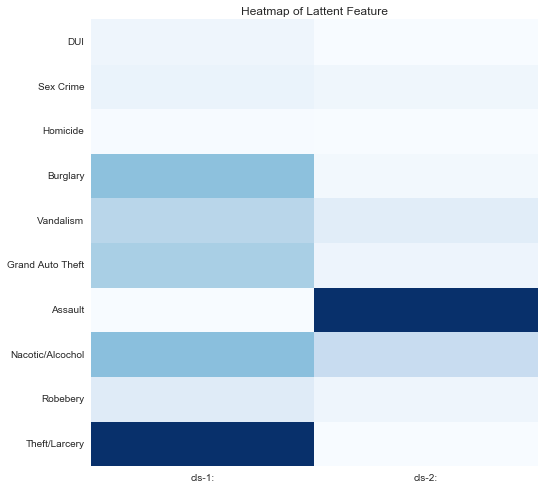

NMF done!


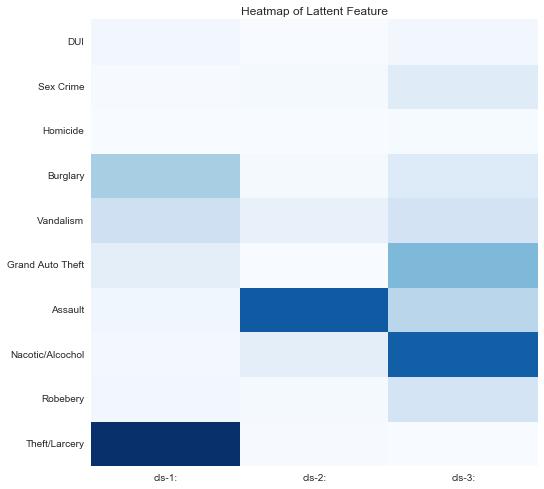

NMF done!


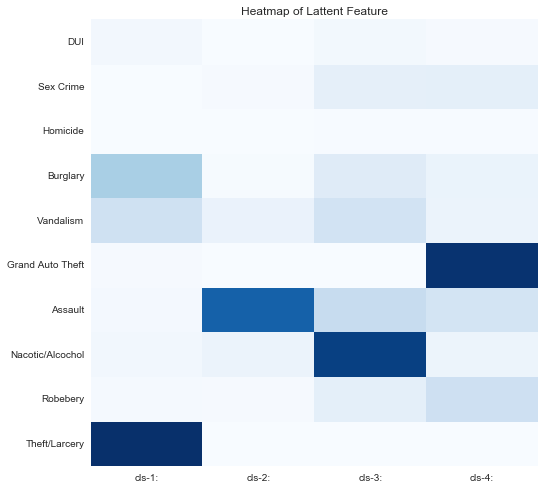

NMF done!


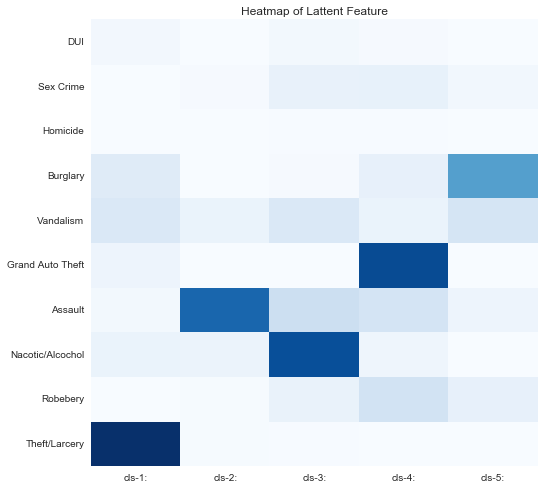

NMF done!


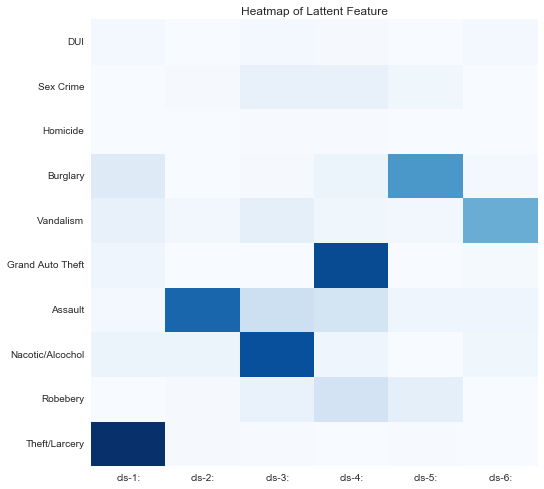

NMF done!


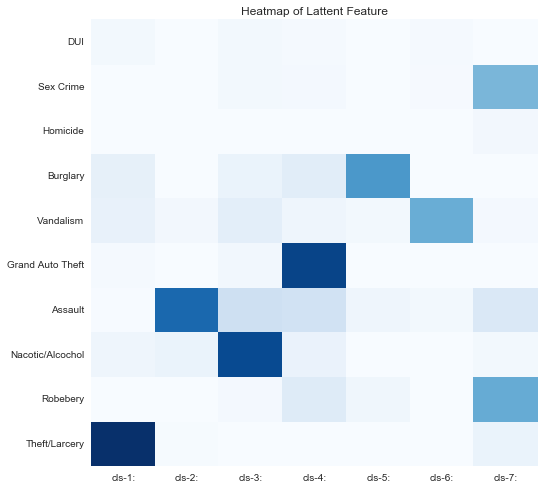

NMF done!


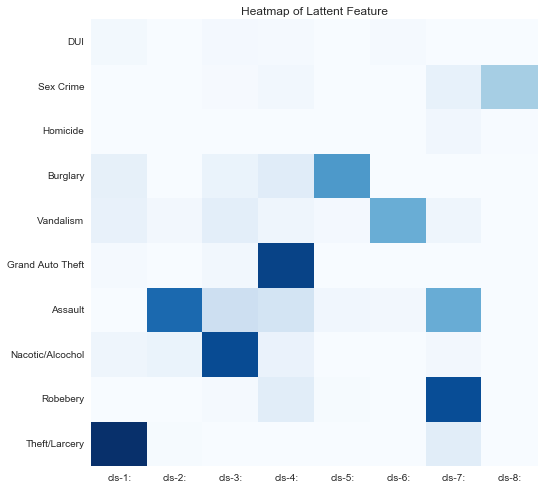

NMF done!


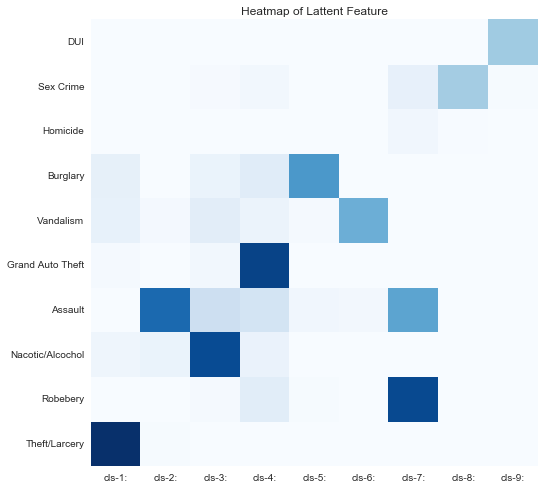

NMF done!


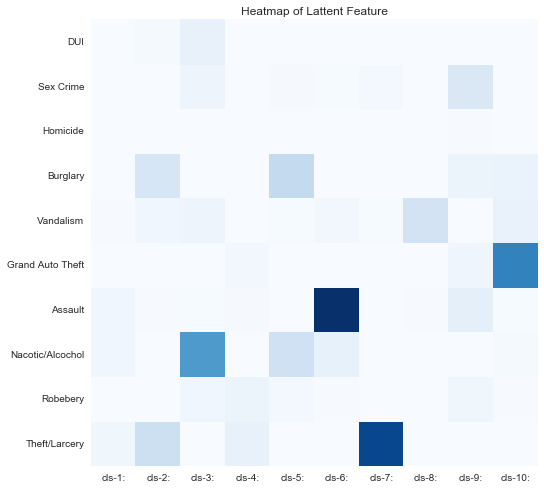

In [37]:
try_different_k_class(X_yr)

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_yr_sca = scaler.fit_transform(X_yr)

NMF done!


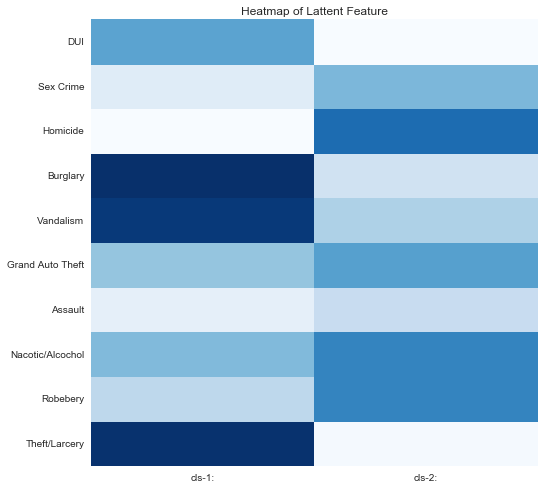

NMF done!


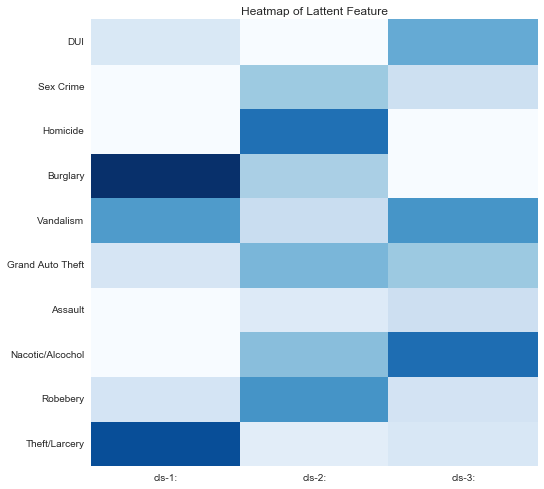

NMF done!


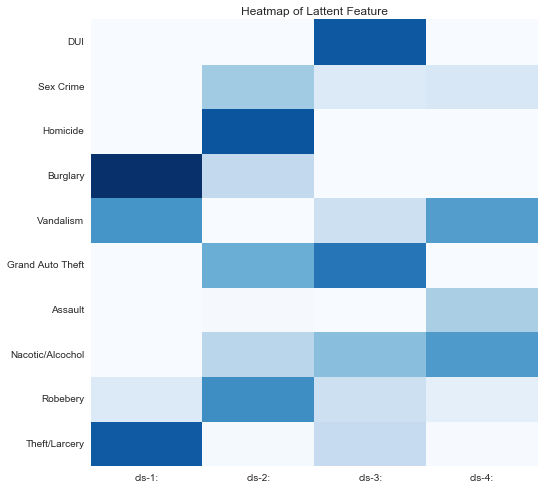

NMF done!


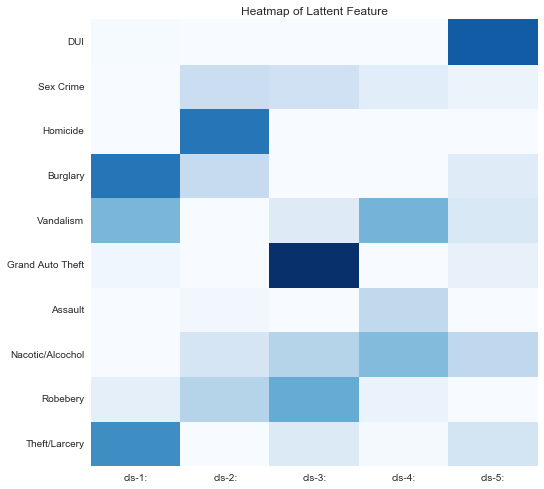

NMF done!


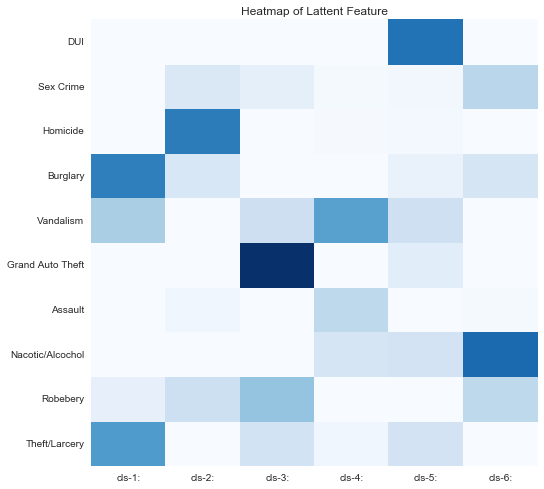

NMF done!


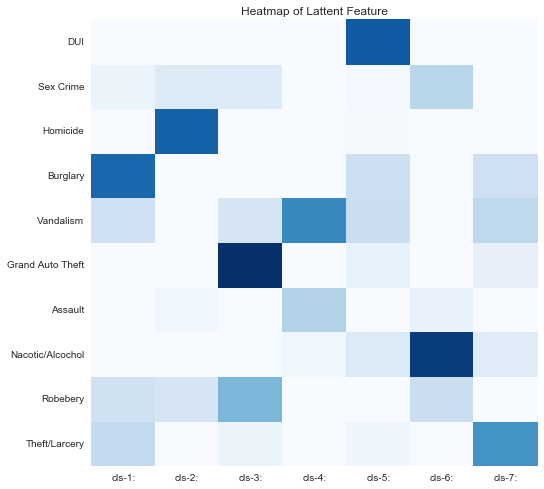

NMF done!


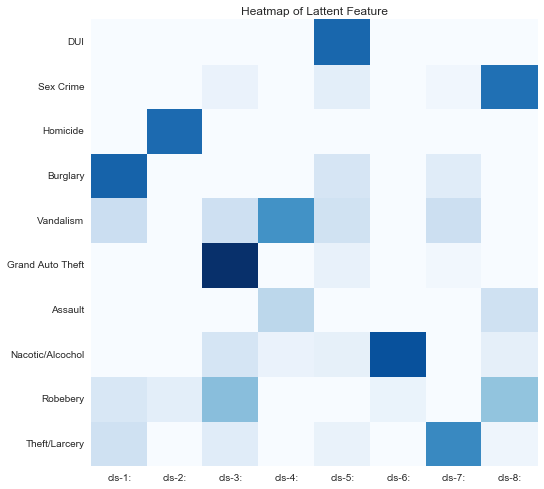

NMF done!


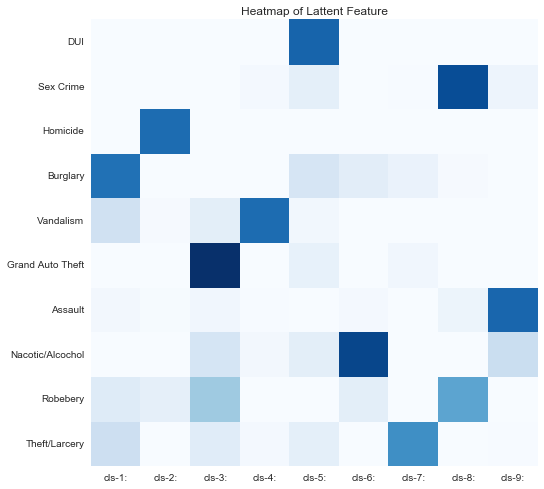

NMF done!


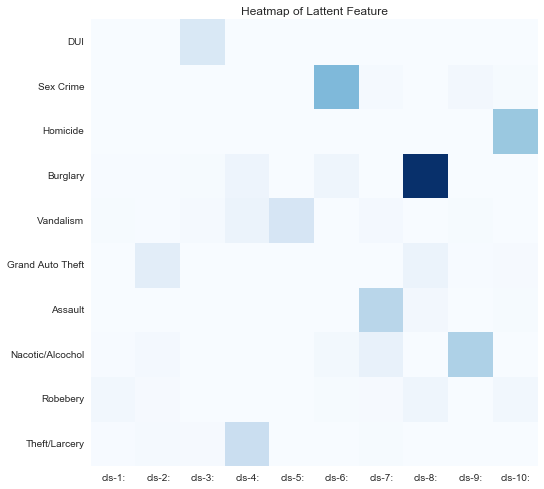

In [39]:
try_different_k_class(X_yr_sca)

NMF done!


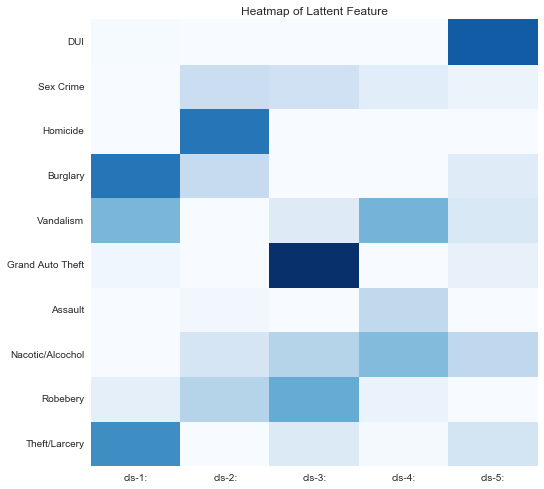

In [40]:
W, H = build_nmf_all(X_yr_sca, 5)
labelsNMF = W.argmax(axis=1)

In [41]:
from pysal.esda.mapclassify import Natural_Breaks
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def prep_df(df, W, labels):
    W_df= W = pd.DataFrame(W)
    for col in W.columns:
        W.loc[:,col] = Natural_Breaks(W.loc[:, col], k=10).yb
    df['class'] = labels + 1
    df = pd.concat((df.drop(range(1,11), axis=1), W), axis=1)
    df['ZIP'] = df['ZIP'].apply(int).apply(str)
    return df

def get_df_map(df):
    df_map = pd.DataFrame({
            'poly': [Polygon(xy) for xy in m.LA],
            'zipcode': [ward['zipcode'] for ward in m.LA_info]})
    df_map = pd.merge(df_map, df, how='left', left_on='zipcode', right_on='ZIP',
                      left_index=True, right_index=False)
    df_map = df_map.fillna(0)
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1.0, zorder=4))
#     print df_map.head()
    return df_map

def build_yr_map_nmf(df_map):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    # draw wards with grey outlines
    norm = Normalize()
    cmaps = []
    colors = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples']
    for i in xrange(5):
        color = colors[i]
        cmap = plt.get_cmap(color)
        pc = PatchCollection(df_map[df_map['class'] == i+1]['patches'], match_original=True, alpha=0.8)
        pc.set_facecolor(cmap(norm(df_map.loc[(df_map['class'] == i+1), i].values)))
        ax.add_collection(pc)
    pc = PatchCollection(df_map[df_map['class'] == 0]['patches'], match_original=True, alpha=0.2)
    pc.set_facecolor('Grey')
    ax.add_collection(pc)
    info = 'LA Commuties Categoried by Crime -- {}'.format(yr)

    # Draw a map scale
    m.drawmapscale(
        coords[0] + 0.2, coords[1] + 1.015,
        coords[0], coords[1],
        20.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555', units='mi',
        zorder=5)
    # this will set the image width to 722px at 100dpi
    plt.tight_layout()
    fig.set_size_inches(12, 16)
    # plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
    plt.show()
    
# df_map = get_df_map(layr, 2004, labelsNMF, W)

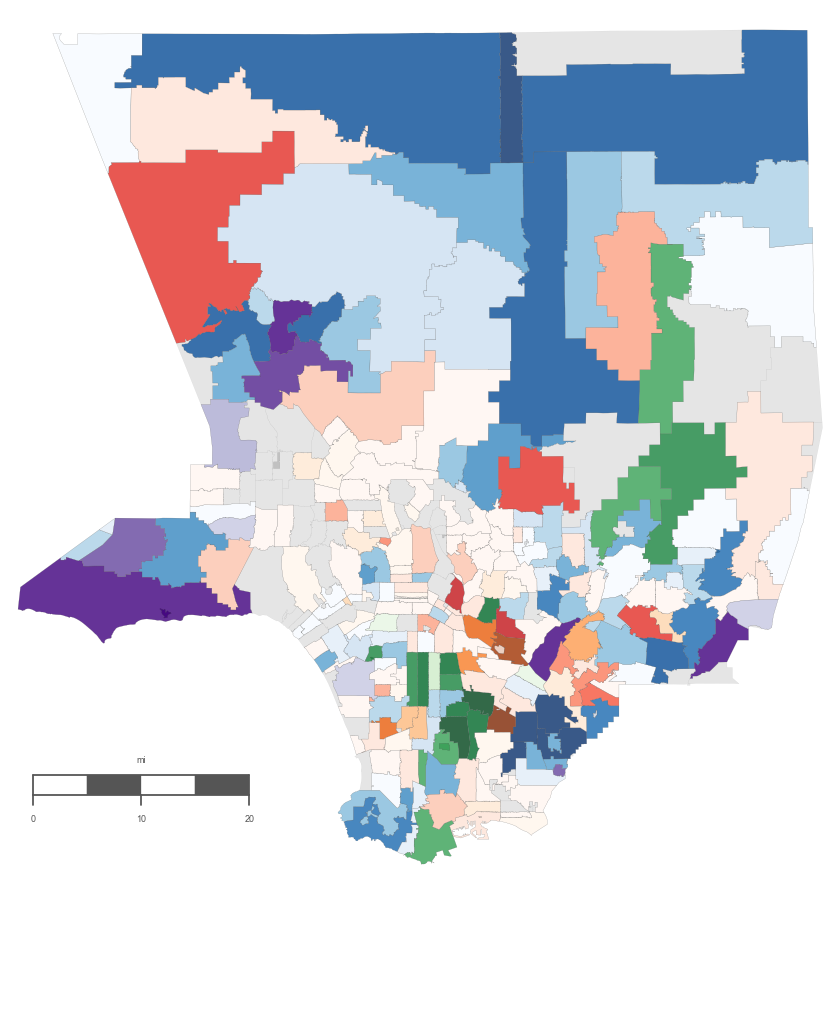

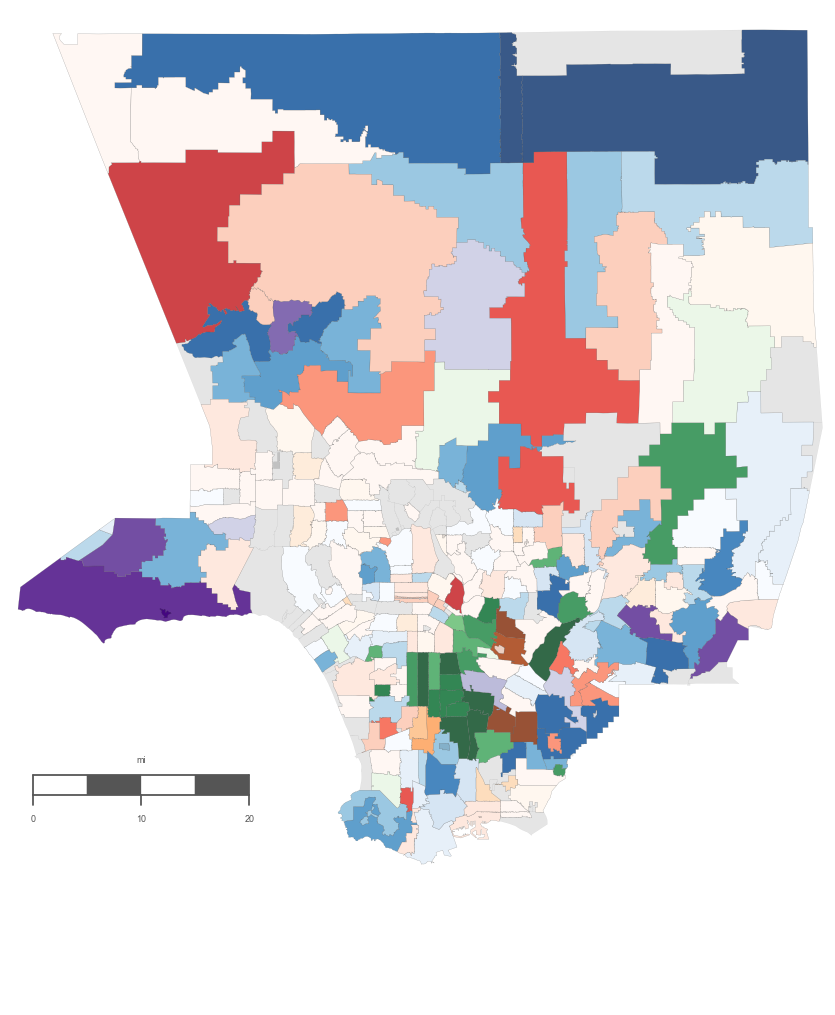

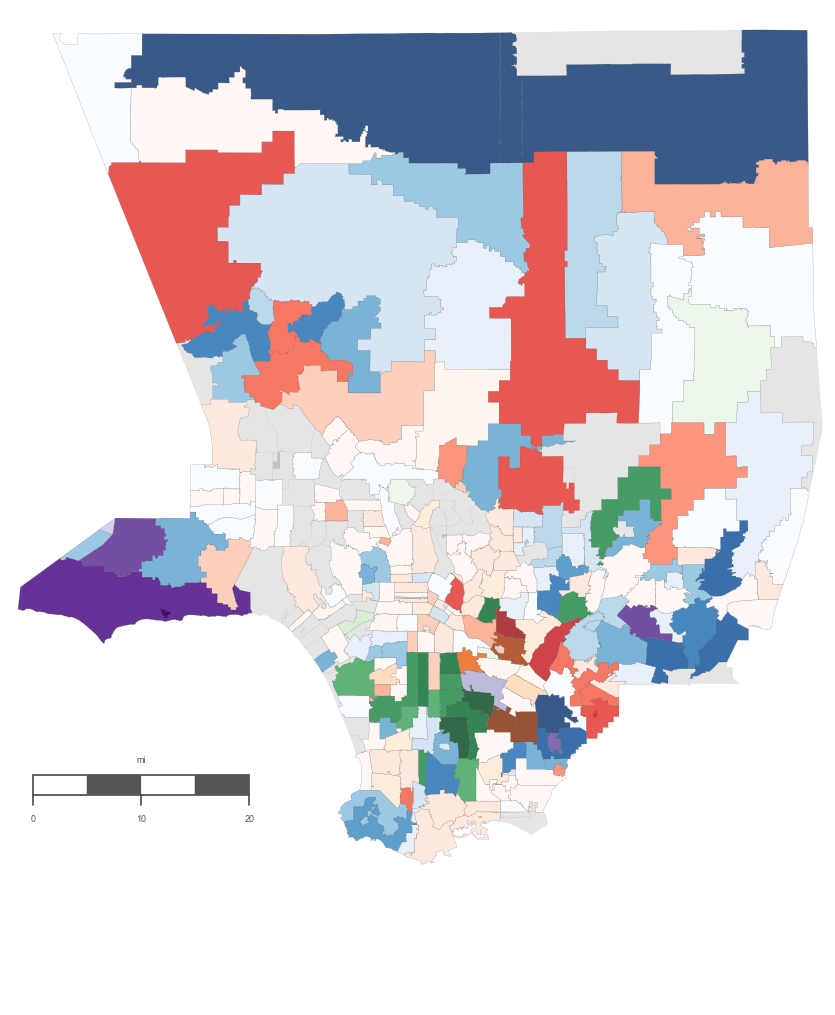

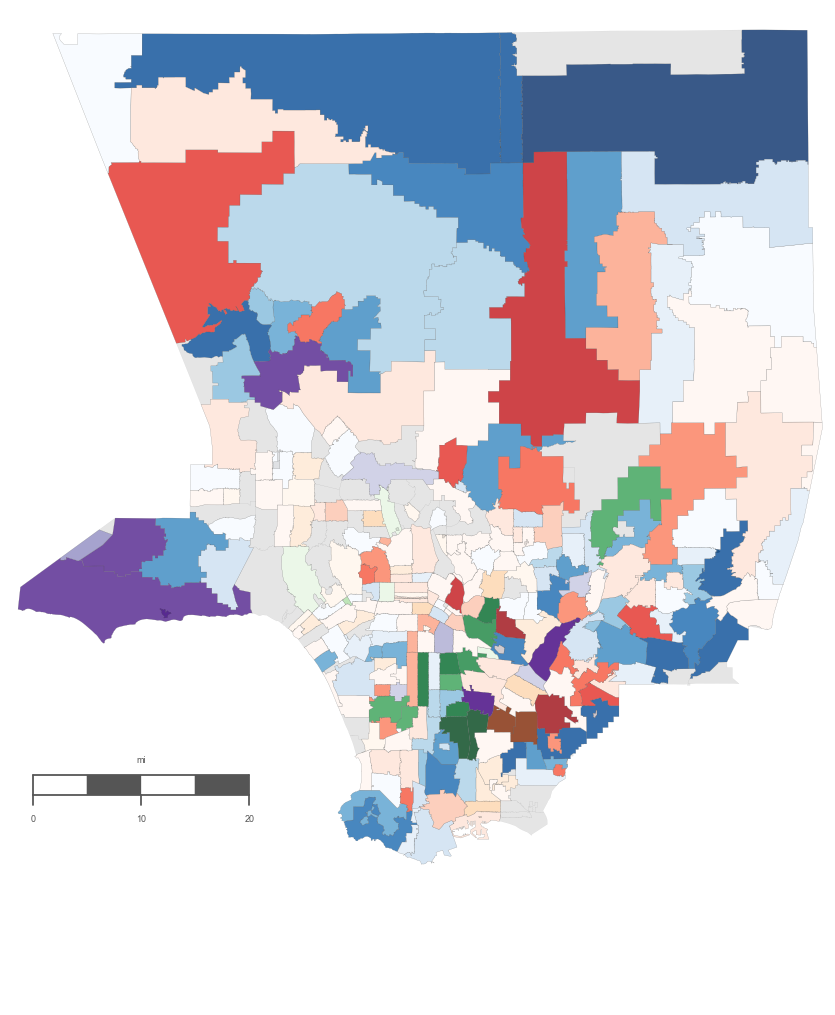

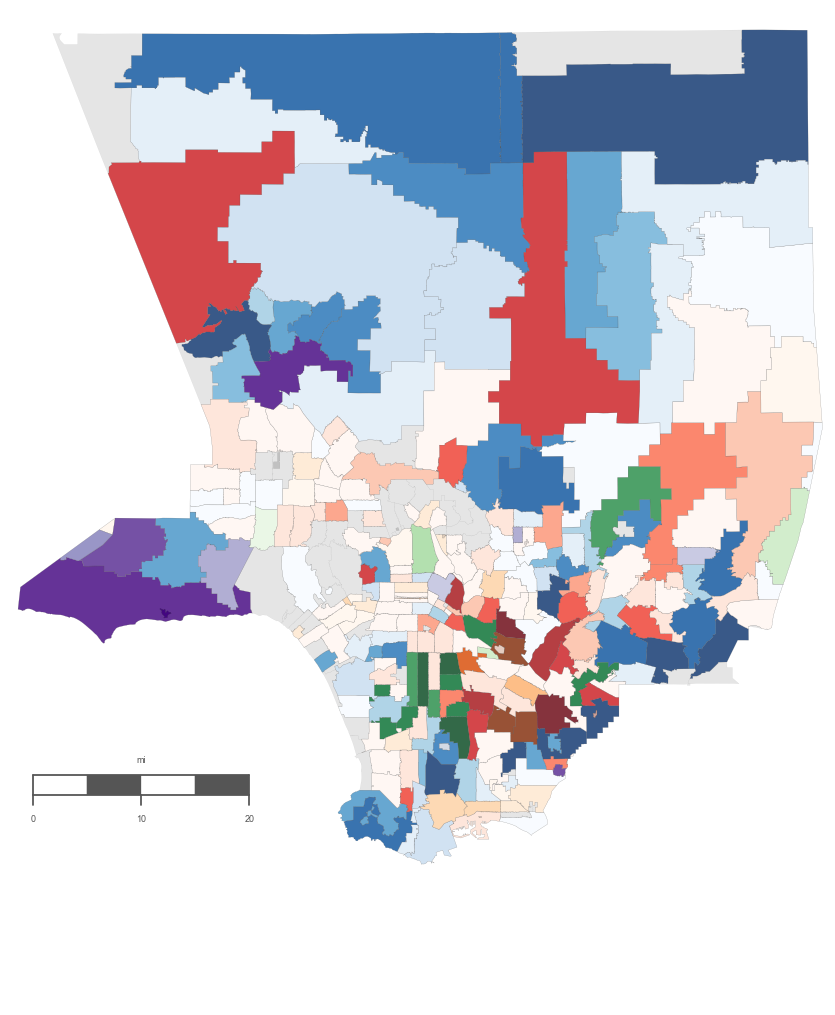

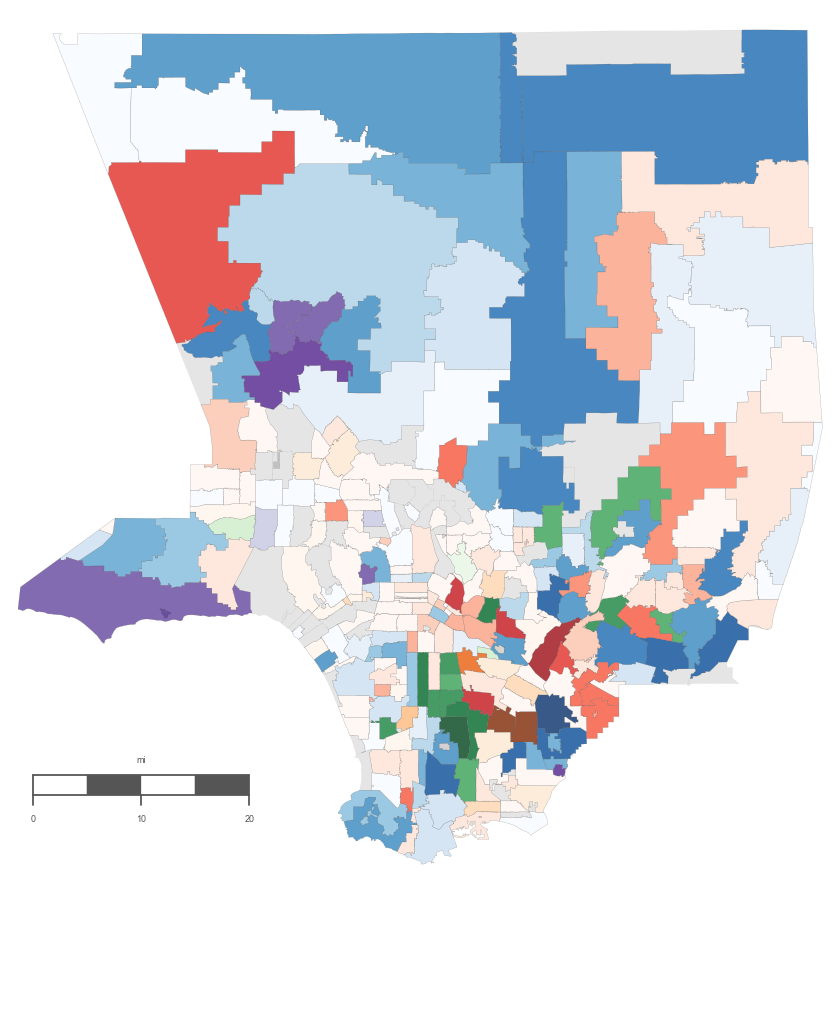

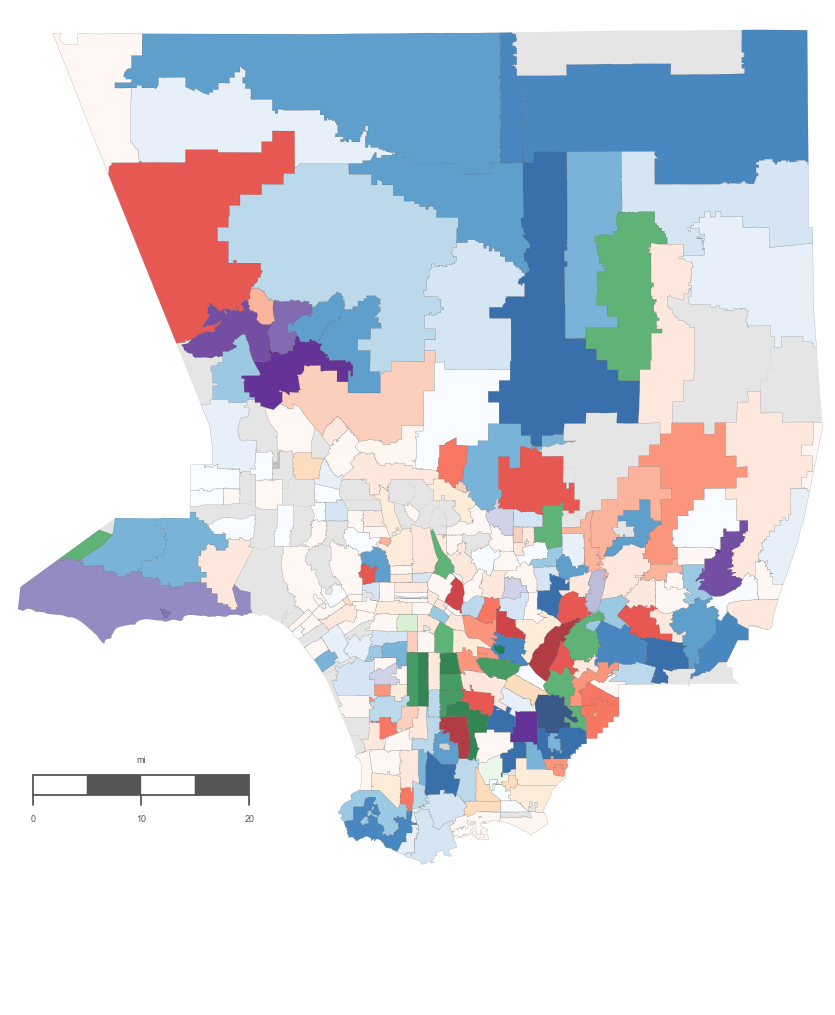

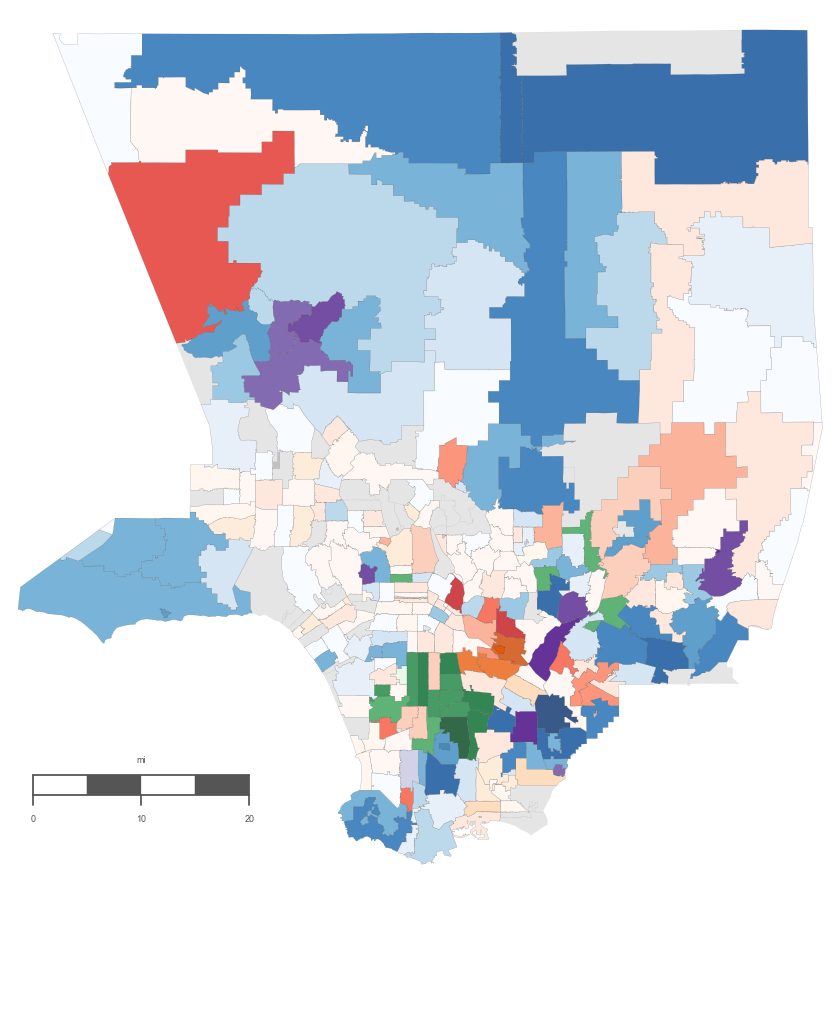

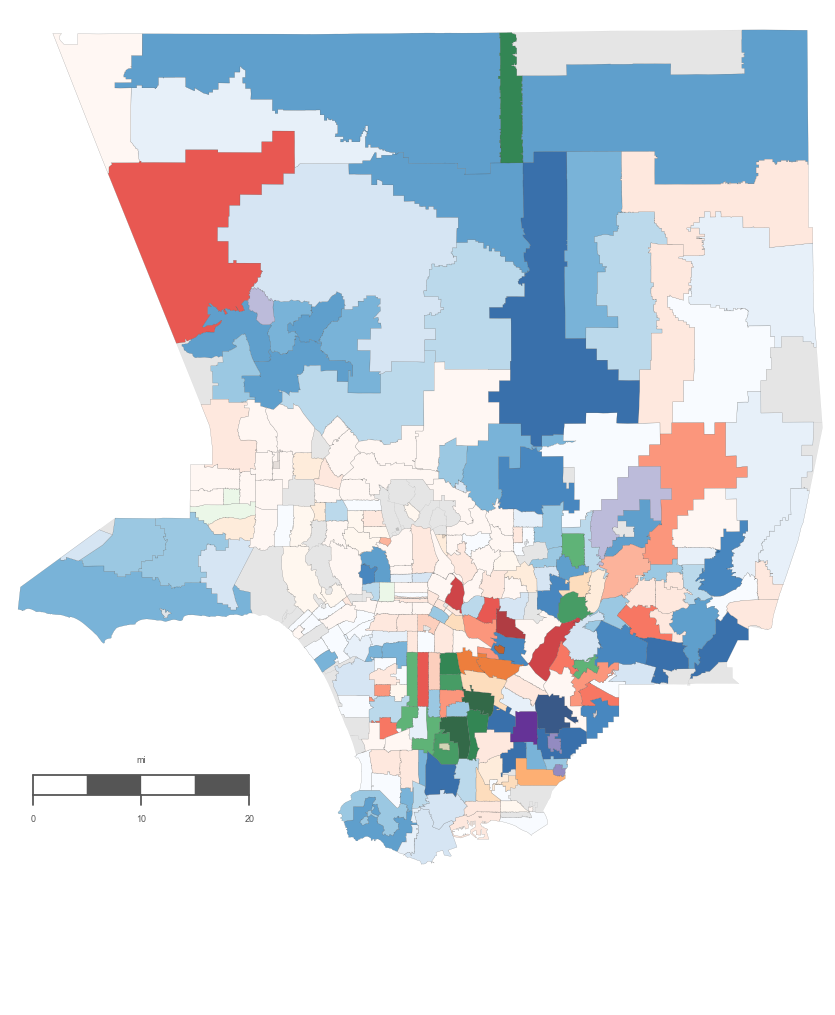

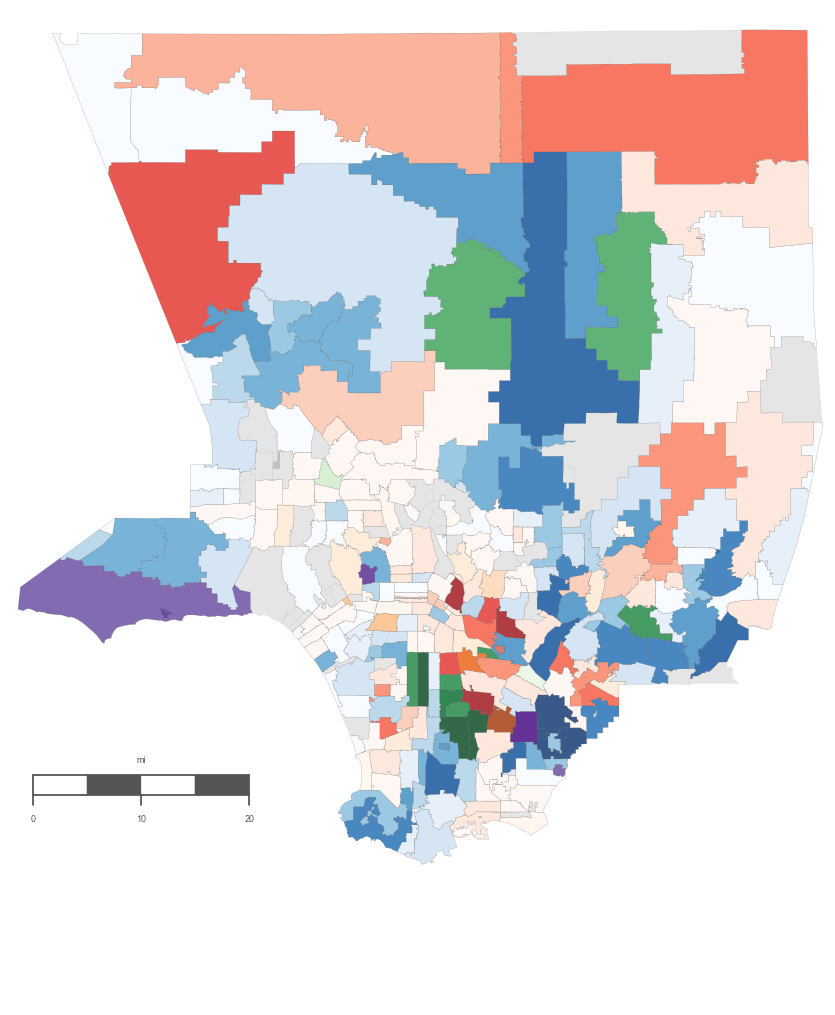

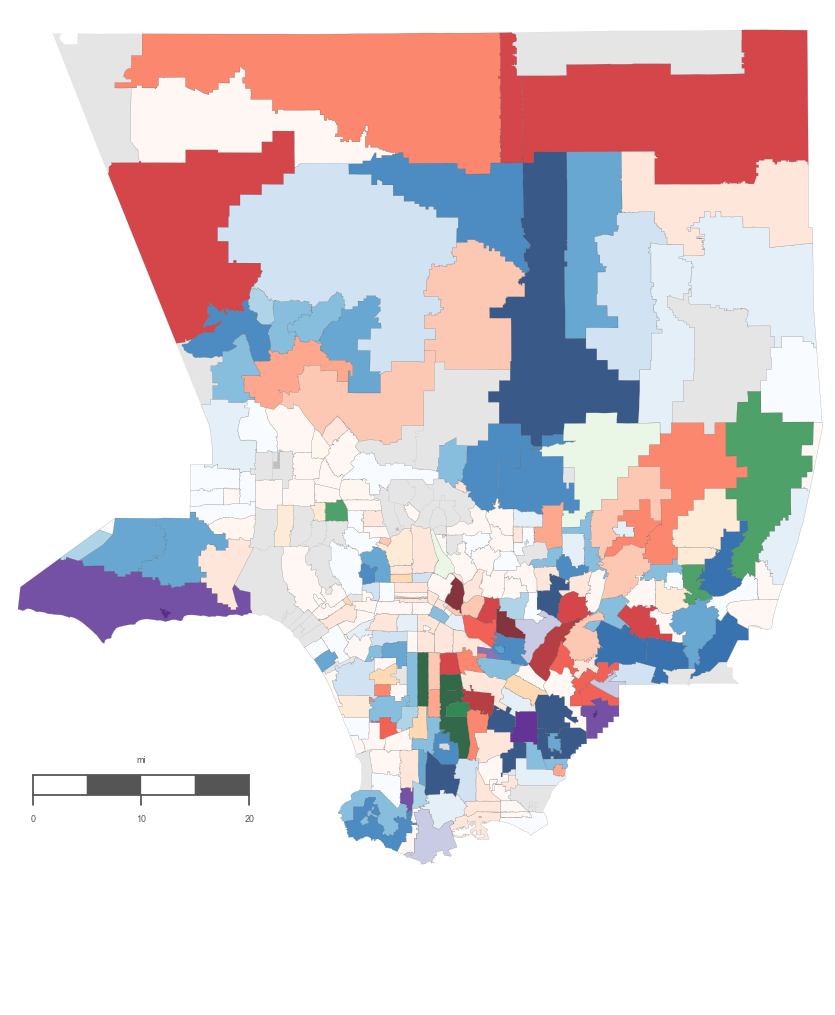

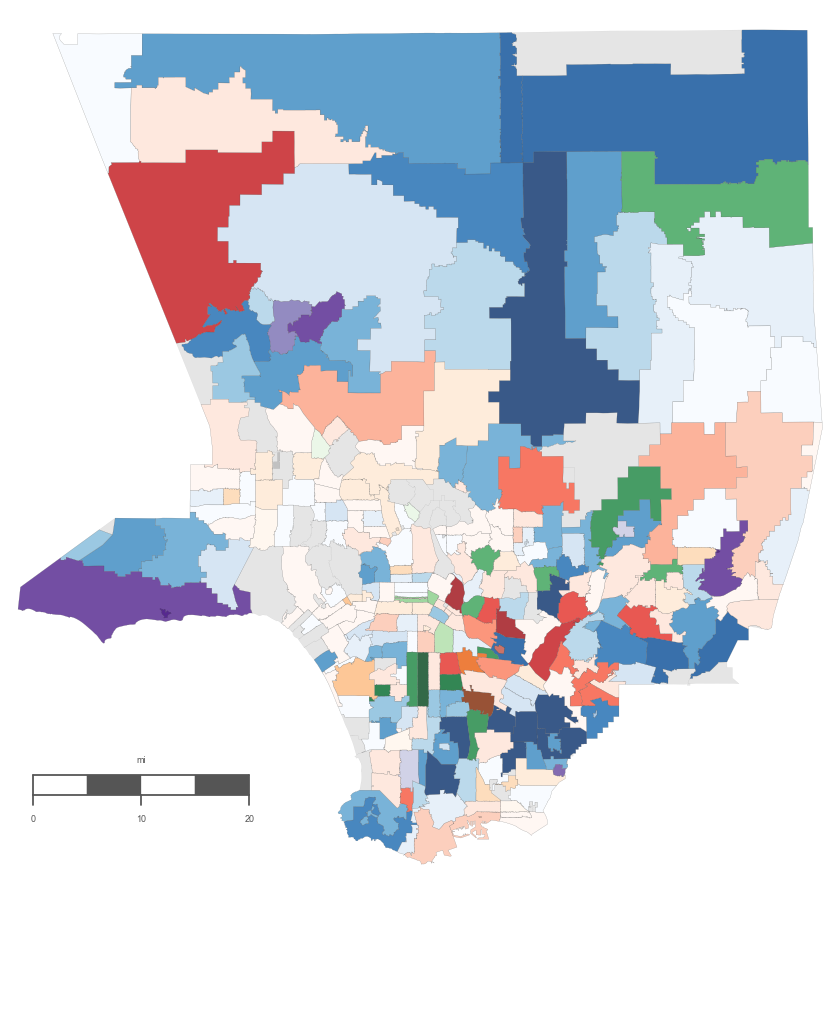

In [42]:
new_df = prep_df(layr, W, labelsNMF)
for yr in xrange(2004, 2016):
    df_map = get_df_map(new_df[new_df['Year'] == yr])
    build_yr_map_nmf(df_map)

In [43]:
W.argmax(axis=1) + 1

array([3, 2, 2, ..., 1, 1, 1])

In [44]:
labelsNMF

array([2, 1, 1, ..., 0, 0, 0])